In [1]:
from mvpa2.suite import *
import bids
import bids.grabbids as gb
from os.path import join as opj
import csv
import glob
import pdb
import pickle
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, mannwhitneyu

/home/mcasey/.conda/envs/pymvpa/lib/python2.7/site-packages/mvpa2/base/hdf5.py:40: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  import h5py.highlevel  # >= 2.8.0, https://github.com/h5py/h5py/issues/1063
/home/mcasey/.conda/envs/pymvpa/lib/python2.7/site-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pl.rcParams['figure.figsize']=(12,6)

<h2>Decoding Model for Heard / Imagined Pitch and Timbre</h2>
<h3>Michael A. Casey, Dartmouth College, Aug 2019</h3>
<h2>Assemble pre-processed datasets</h2>

data = 3mmx3mmx3mm


In [3]:
DATADIR='/isi/music/auditoryimagery2/am2/data/fmriprep/fmriprep/'
MRISPACE= 'MNI152NLin2009cAsym' #'MNI152NLin6Asym' 
PARCELLATION='desc-aparcaseg_dseg'
subjects = ['sid001401', 'sid000388', 'sid001415', 'sid001419', 'sid001410']
accessions = {'sid001401':'A002636', 
                  'sid000388':'A002655', 
                  'sid001415':'A002652', 
                  'sid001419':'A002659', 
                  'sid001410':'A002677'}

# Read run_legend to re-order runs by task
with open('/isi/music/auditoryimagery2/targets/run_legend.csv') as csvfile:
    legend={}
    for subj, acc in accessions.items():
        legend[acc]=[]
    reader = csv.reader(csvfile, delimiter=',')    
    for row in reader:
        legend[row[0]].append(row[2])
        

def get_subject_mask(subject, run=1, rois=[1030,2030], path=DATADIR, 
                     space=MRISPACE,
                     parcellation=PARCELLATION):
    # rois are in ${DATADIR}/fmriprep/desc-aparcaseg_dseg.tsv   
    fname = opj(path, subject, 'func', '%s_task-*_run-%02d_space-%s_%s.nii.gz'%(subject,run,space, parcellation))
    #print fname
    fname = glob.glob(fname)[0]
    ds=fmri_dataset(fname)
    found=np.where(np.isin(ds.samples,rois))[1]
    return ds[:,found]

def get_all_subjects_ds(**kwargs):
    # kwargs -- for get_subject_mask
    #
    swap_runs=[2,1,4,3,6,5,8,7]
    layout = gb.BIDSLayout(DATADIR)
    ext = 'desc-preproc_bold.nii.gz'
    data = {}
    rois=kwargs.get('rois', None)
    for subject in subjects:
        data[subject]=[]
        if rois:
            mask = map2nifti(get_subject_mask('sub-%s'%subject, **kwargs))
            print "mask.shape:", mask.shape
        else:
            mask = None
            print "no mask"
        for run in range(1,9):
            r=run if legend[accessions[subject]][0]=='HT' else swap_runs[run-1]
            f=layout.get(subject=subject, extensions=[ext], run=r)[0]
            tgts=np.loadtxt(opj('targets', accessions[subject]+'_run-%02d.txt'%r)).astype('int')                        
            ds = fmri_dataset(f.filename,
                             targets=tgts,
                             chunks=run,
                             mask=mask)
            if not ds.shape[1]:
                raise ValueError("Got zero mask (no samples)")
            
            print "subject", subject, "chunk", run, "run", r, "ds", ds.shape 
            data[subject].append(ds)
        data[subject]=vstack(data[subject], a=0)
    print "got", len(data), ext, "datasets"
    return data

<h2>Load all subjects' masked data</h2>

In [22]:
roi_map={
1000:    "ctx-lh-unknown",        #190519
1001:    "ctx-lh-bankssts",       #196428
1002:    "ctx-lh-caudalanteriorcingulate", #7d64a0
1003:    "ctx-lh-caudalmiddlefrontal",    #641900
1004:    "ctx-lh-corpuscallosum", #784632
1005:    "ctx-lh-cuneus", #dc1464
1006:    "ctx-lh-entorhinal",     #dc140a
1007:   "ctx-lh-fusiform",       #b4dc8c
1008:    "ctx-lh-inferiorparietal",       #dc3cdc
1009:    "ctx-lh-inferiortemporal",       #b42878
1010:    "ctx-lh-isthmuscingulate",       #8c148c
1011:    "ctx-lh-lateraloccipital",       #141e8c
1012:    "ctx-lh-lateralorbitofrontal",   #234b32
1013:    "ctx-lh-lingual",        #e18c8c
1014:    "ctx-lh-medialorbitofrontal",    #c8234b
1015:    "ctx-lh-middletemporal", #a06432
1016:    "ctx-lh-parahippocampal",        #14dc3c
1017:    "ctx-lh-paracentral",    #3cdc3c
1018:    "ctx-lh-parsopercularis",        #dcb48c
1019:    "ctx-lh-parsorbitalis",  #146432
1020:    "ctx-lh-parstriangularis",       #dc3c14
1021:    "ctx-lh-pericalcarine",  #78643c
1022:    "ctx-lh-postcentral",    #dc1414
1023:    "ctx-lh-posteriorcingulate",     #dcb4dc
1024:    "ctx-lh-precentral",     #3c14dc
1025:    "ctx-lh-precuneus",      #a08cb4
1026:    "ctx-lh-rostralanteriorcingulate",       #50148c
1027:    "ctx-lh-rostralmiddlefrontal",   #4b327d
1028:    "ctx-lh-superiorfrontal",        #14dca0
1029:    "ctx-lh-superiorparietal",       #14b48c
1030:    "ctx-lh-superiortemporal",       #8cdcdc
1031:    "ctx-lh-supramarginal",  #50a014
1032:    "ctx-lh-frontalpole",    #640064
1033:    "ctx-lh-temporalpole",   #464646
1034:    "ctx-lh-transversetemporal",     #9696c8
1035:    "ctx-lh-insula" #ffc020
}

# Generate RH cortical map
for k in roi_map.keys():
    roi_map[k+1000]=roi_map[k].replace('lh','rh')

if 1: # LOAD ALL SUBJECTS DATA, NO MASK
    data = get_all_subjects_ds()

/home/mcasey/.conda/envs/pymvpa/lib/python2.7/site-packages/grabbit/core.py:410: UserWarning: No valid root directory found for domain 'derivatives'. Falling back on the Layout's root directory. If this isn't the intended behavior, make sure the config file for this domain includes a 'root' key.
  "'root' key." % config['name'])


no mask
 * Please note: warnings are printed only once, but underlying problem might occur many times *
subject sid001401 chunk 1 run 1 ds (233, 325325)
subject sid001401 chunk 2 run 2 ds (233, 325325)
subject sid001401 chunk 3 run 3 ds (233, 325325)
subject sid001401 chunk 4 run 4 ds (233, 325325)
subject sid001401 chunk 5 run 5 ds (233, 325325)
subject sid001401 chunk 6 run 6 ds (233, 325325)
subject sid001401 chunk 7 run 7 ds (233, 325325)
subject sid001401 chunk 8 run 8 ds (233, 325325)
no mask
subject sid000388 chunk 1 run 2 ds (233, 325325)
subject sid000388 chunk 2 run 1 ds (233, 325325)
subject sid000388 chunk 3 run 4 ds (233, 325325)
subject sid000388 chunk 4 run 3 ds (233, 325325)
subject sid000388 chunk 5 run 6 ds (233, 325325)
subject sid000388 chunk 6 run 5 ds (233, 325325)
subject sid000388 chunk 7 run 8 ds (233, 325325)
subject sid000388 chunk 8 run 7 ds (233, 325325)
no mask
subject sid001415 chunk 1 run 1 ds (233, 325325)
subject sid001415 chunk 2 run 2 ds (233, 325325

<h3>Inspect Raw and Preprocessed Data (detrended / z-scored)</h3>


In [14]:
if 0:
    # Inspect original BOLD data
    ds=data[subjects[1]].copy(deep=True)
    pl.figure()
    pl.plot(ds.samples[:,450:550])
    pl.title('Original BOLD data',fontsize=20)
    pl.xlabel('TR',fontsize=16)
    pl.ylabel('BOLD signal',fontsize=16)
    pl.axis('tight')
    fig=pl.grid()


    # Inspect Detrended/Z-scored BOLD data
    ds2=ds.copy(deep=True)
    poly_detrend(ds2, polyord=1, chunks_attr='chunks') # in-place
    zscore(ds2, param_est=('targets', [1,2])) # in-place

    pl.figure()
    pl.plot(ds2.samples[:,450:550])
    pl.title('Detrended/z-scored BOLD data',fontsize=20)
    pl.xlabel('TR',fontsize=16)
    pl.ylabel('BOLD signal',fontsize=16)
    pl.axis('tight')
    fig=pl.grid()


<h2>Within-Subject Results: Classification and Staistics</h2>

In [20]:
# DEPRECATED: SEE BELOW
# tasks=['praw','pclass','pheight','timbre']

# def do_classification(data, task=tasks[1], condition='a', clf=None, null_model=False): #nf=50): 
#     # task - choose the clf task
#     # condition - choose the condition h/i/a
#     # clf - the classifier (LinearCSVMC)
#     clf=LinearCSVMC() if clf is None else clf
#     res = []
#     cvs = []
#     #svdmapper = SVDMapper()
#     #get_SVD_sliced = lambda x: ChainMapper([svdmapper,StaticFeatureSelection(x)])
#     for subject in subjects:
#         ds = data[subject].copy(deep=True) # copy the data
#         poly_detrend(ds, polyord=1, chunks_attr='chunks') # in-place
#         zscore(ds, param_est=('targets', [1,2])) # in-place
#         ds = ds[(ds.targets>99) & (ds.targets<1000)] # take only pitch targets
#         if task==tasks[1]: # pclass
#             ds.targets = (ds.targets % 100) % 12
#         elif task==tasks[2]:
#             ds.targets = (ds.targets % 100)
#             ds = ds[(ds.targets<=66) | (ds.targets>75)]
#             ds.targets[ds.targets<=66]=1
#             ds.targets[ds.targets>75]=2        
#         elif task==tasks[3]:  # timbre
#             ds.targets = ds.chunks % 2
#         if condition[0]=='h':
#             ds = ds[(ds.chunks==1)|(ds.chunks==2)|(ds.chunks==5)|(ds.chunks==6)]
#         elif condition[0]=='i':
#             ds = ds[(ds.chunks==3)|(ds.chunks==4)|(ds.chunks==7)|(ds.chunks==8)]
#         if null_model:
#             ds.targets = np.random.permutation(ds.targets) # scramble pitch targets
#         cv = CrossValidation(clf, #MappedClassifier(clf,get_SVD_sliced(slice(0, nf))) 
#                              HalfPartitioner(), errorfx=mean_match_accuracy, enable_ca=['stats']) #errorfx=None, postproc=None) for raw predictions
#         cvs.append(cv)
#         res.append(cv(ds))
#         #print cv.ca.stats.as_string(description=False)
#     return {'subj':subject, 'res':res, 'cv': cvs, 'task':task, 'condition':condition, 'ut':ds.UT}

# def show_results(res):
#     print "task=%s, condition=%s, unique targets=%d"%(res['task'], res['condition'], len(res['ut']))
#     print "baseline=%5.2f%%"%(100.0 / len(res['ut']))
#     print "==============="
#     all_res=array([100*np.mean(r) for r in res['res']])
#     for k,r in zip(subjects,all_res):
#         print k,'%5.2f%%'%r
#     print "================"
#     print "mean:%5.2f%%"%all_res.mean()
#     print "================\n"

# def evaluate_all_tasks(null_model=False):
#     # Evaluate all tasks
#     # try:
#     #    clf=LinearCSVMC()
#     #    clf=SMLR()
#     #    clf=SVM(svm_impl='NU_SVR', nu=nu, kernel=RbfSVMKernel(gamma=gamma))
#     res = {}
#     for task in tasks[::-1]:
#         print "\n**** %s ****"%task.upper()
#         res[task]={}
#         for condition in ['a','h','i']:
#             res[task][condition] = do_classification(data, task, condition, clf=LinearCSVMC(),null_model=null_model)
#             show_results(res[task][condition])
#     return res

In [6]:
# DEPRECATED, SEE GROUP ANALYSIS BELOW
#res_all = evaluate_all_tasks()

In [7]:
# DEPRECATED, SEE GROUP ANALYSIS BELOW
#null_all = evaluate_all_tasks(null_model=True)

In [8]:
# # Show cv.ca.stats.as_string()
# for subj in range(5):
#     r=res_all['pclass']['h']['res'][subj]
#     c=res_all['pclass']['h']['cv'][subj]
#     print "Partitions acc:",(100*r.samples.flatten()).round(2), "mean acc:%6.2f"%(100*r.samples.flatten().mean())
#     print c.ca.stats.as_string()

<h2>Between-Subject Group Model / Null Monte-Carlo Test</h2>

In [55]:
def do_subj_classification(ds, subject, task='timbre', condition='a', clf=None, null_model=False): #nf=50): 
    # task - choose the clf task
    # condition - choose the condition h/i/a
    # clf - the classifier (LinearCSVMC)
    clf=LinearCSVMC() if clf is None else clf
    poly_detrend(ds, polyord=1, chunks_attr='chunks') # in-place
    zscore(ds, param_est=('targets', [1,2])) # in-place
    ds = ds[(ds.targets>99) & (ds.targets<1000)] # take only pitch targets
    if task==tasks[1]: # pch-class
        ds.targets = (ds.targets % 100) % 12
    elif task==tasks[2]: # pch-hi-lo
        ds.targets = (ds.targets % 100)
        ds = ds[(ds.targets<=66) | (ds.targets>75)]
        ds.targets[ds.targets<=66]=1
        ds.targets[ds.targets>75]=2
    elif task==tasks[3]:  # timbre
        ds.targets = ds.chunks.copy() % 2
    if condition[0]=='h':
        ds = ds[(ds.chunks==1)|(ds.chunks==2)|(ds.chunks==5)|(ds.chunks==6)]
    elif condition[0]=='i':
        ds = ds[(ds.chunks==3)|(ds.chunks==4)|(ds.chunks==7)|(ds.chunks==8)]
    if null_model:
        ds.targets = np.random.permutation(ds.targets) # scramble pitch targets
    cv = CrossValidation(clf, HalfPartitioner(), errorfx=None, postproc=None) # Raw predictions
    res=cv(ds)
    return {'subj':subject, 'res':res, 'cv': cv, 'task':task, 'condition':condition, 'ut':ds.UT}

def ttest_result(data, task, cond, rois=[1030,2030], n_null=10, clf=None, show=False, null_model=False):
    res=[]
    null=[]
    clf = LinearCSVMC() if clf is None else clf
    for subj in subjects:
        ds=data[subj]
        mask = get_subject_mask('sub-%s'%subj, run=1, rois=rois)
        mapper=mask_mapper(mask.samples.astype('i'))
        mapper.train(ds)
        ds = data[subj].get_mapped(mapper)
        r=do_subj_classification(ds, subj, task, cond, clf=clf, null_model=False)
        res.append([r['res'].targets, r['res'].samples.flatten()])
        if null_model:
            for _ in range(n_null):
                n=do_subj_classification(ds, subj, task, cond, clf=clf, null_model=True)
                null.append([n['res'].targets, n['res'].samples.flatten()])
    res=array(res)
    a = (res[:,0,:]==res[:,1,:]).mean(1)
    ae = a.std() / np.sqrt(len(a))
    am=a.mean()
    if null_model:
        null=array(null)
        b = (null[:,0,:]==null[:,1,:]).mean(1)
        bm=b.mean()
        be = b.std() / np.sqrt(len(b))
    else:
        b=0.0
        bm=0.0
        be=0.0
    conds={'h':'Heard','i':'Imag'}
    L = 21
    bl = 1.0 / len(r['ut'])
    tt = ttest_1samp(a, bl , alternative='greater') # pymvpa's ttest_1samp
    wx = (0,0) # samp size too small for wilcoxon(a-bl) # non-parametric version of ttest_1samp
    print "TT:(%4.1f, %0.6f)"%(tt[0],tt[1]),"WX:(%4.1f, %0.6f)"%(wx[0],wx[1])
    if show:
        pl.figure()
        if null_model:
            hst,bins,ptch=pl.hist(np.c_[a,b],np.linspace(0, 1, L+1), histtype='bar')
        else:
            hst,bins,ptch=pl.hist(a,np.linspace(0, 1, L+1), histtype='bar')            
        leg=['True','Null','Baseline'] if null_model else ['True','Baseline']
        pl.legend(leg,fontsize=16)
        pl.xlabel('Acc',fontsize=16)
        pl.ylabel('Freq',fontsize=16)
        pl.title('Task: %s(%s), T=%7.1f, p=%7.5f, mn=%5.3f/bl=%5.3f'%(task.upper(),conds[cond],tt[0],tt[1], a.mean(), bl),fontsize=20)
        ax=pl.gca()
        ax.set_xlim(0,1)
        mx = ax.get_ylim()[1]
        pl.plot([bl, bl],[0, 0.9*mx],'r--',alpha=0.5,linewidth=3)
        roi_str='ROI:'.join([' '+roi_map[roi].replace('ctx-','').upper() for roi in rois])
        pl.text(0.33,ax.get_ylim()[1]*0.925, roi_str, {'fontsize':20})
        f=pl.grid()
        pl.show()
    return {'tt':tt, 'wx':wx, 'mn':am, 'se':ae, 'mn0':bm, 'se0':be, 'ut': r['ut']}

In [56]:
# GENERATE LOTS OF FIGURES, GROUP-LEVEL ANALYSIS for TASK x ROI x COND x HEMI

# List of tasks to evaluate
tasks=['pch-height','pch-class','pch-hi-lo','timbre']
# Cortical regions of interest, group_results are L-R lateralized with R=roi_id + 1000
rois = range(1000,1036) #[1001, 1012, 1014, 1015, 1022, 1023, 1024, 1027, 1028, 1030, 1031, 1034, 1035]
rois.pop(rois.index(1004)) # corpuscallosum is degenerate, so remove it from the list of ROIs

def calc_group_results(rois, tasks, group_res=None, null_model=False):
    if group_res is None:
        group_res = {}
    for task in tasks[::-1]:
        if task not in group_res.keys():
            group_res[task]={}
        for roi in rois:
            if roi not in group_res[task].keys():
                group_res[task][roi]={}
                for hemi in [0,1000]:
                    hemiL = 'LH' if not hemi else 'RH'
                    group_res[task][roi][hemiL]={}
                    for cond in ['h','i']:
                        # show=True plots hist accuracy for conds x hemi with same bins
                        print task, roi_map[roi+hemi].replace('ctx-',''), cond.upper(),
                        group_res[task][roi][hemiL][cond] = ttest_result(data, task, cond, rois=[roi+hemi], null_model=null_model)
    return group_res

use_cached_group_res = False # LOAD CACHED GROUP RESULTS for ALL TASKS, SUBJECTS, ROIs

if use_cached_group_res:
    with open("group_res.pickle","rb") as f:
        group_res = pickle.load(f)
else: #  not "group_res" in globals()
    group_res=calc_group_results(rois, tasks)

timbre lh-unknown H TT:(-4.7, 0.995497) WX:( 0.0, 0.000000)
timbre lh-unknown I TT:( 0.8, 0.244005) WX:( 0.0, 0.000000)
timbre rh-unknown H TT:( 0.3, 0.402592) WX:( 0.0, 0.000000)
timbre rh-unknown I TT:(-0.1, 0.531817) WX:( 0.0, 0.000000)
timbre lh-bankssts H TT:( 2.6, 0.028854) WX:( 0.0, 0.000000)
timbre lh-bankssts I TT:( 0.0, 0.500000) WX:( 0.0, 0.000000)
timbre rh-bankssts H TT:(-0.2, 0.582934) WX:( 0.0, 0.000000)
timbre rh-bankssts I TT:(-0.2, 0.561214) WX:( 0.0, 0.000000)
timbre lh-caudalanteriorcingulate H TT:( 0.4, 0.358946) WX:( 0.0, 0.000000)
timbre lh-caudalanteriorcingulate I TT:( 0.1, 0.459215) WX:( 0.0, 0.000000)
timbre rh-caudalanteriorcingulate H TT:( 0.7, 0.275141) WX:( 0.0, 0.000000)
timbre rh-caudalanteriorcingulate I TT:( 2.2, 0.043924) WX:( 0.0, 0.000000)
timbre lh-caudalmiddlefrontal H TT:(-2.2, 0.954049) WX:( 0.0, 0.000000)
timbre lh-caudalmiddlefrontal I TT:(-2.2, 0.954405) WX:( 0.0, 0.000000)
timbre rh-caudalmiddlefrontal H TT:( 2.0, 0.060122) WX:( 0.0, 0.0000

/home/mcasey/.conda/envs/pymvpa/lib/python2.7/site-packages/mvpa2/misc/stats.py:180: RuntimeWarning: invalid value encountered in divide
  t = np.divide(d, denom)


 TT:( nan, nan) WX:( 0.0, 0.000000)
timbre lh-isthmuscingulate H TT:( 2.7, 0.026138) WX:( 0.0, 0.000000)
timbre lh-isthmuscingulate I TT:( 0.1, 0.463324) WX:( 0.0, 0.000000)
timbre rh-isthmuscingulate H TT:( 1.0, 0.186950) WX:( 0.0, 0.000000)
timbre rh-isthmuscingulate I TT:( nan, nan) WX:( 0.0, 0.000000)
timbre lh-lateraloccipital H TT:(-0.6, 0.718146) WX:( 0.0, 0.000000)
timbre lh-lateraloccipital I TT:( 1.4, 0.119314) WX:( 0.0, 0.000000)
timbre rh-lateraloccipital H TT:( 1.0, 0.186950) WX:( 0.0, 0.000000)
timbre rh-lateraloccipital I TT:( nan, nan) WX:( 0.0, 0.000000)
timbre lh-lateralorbitofrontal H TT:( 0.7, 0.271795) WX:( 0.0, 0.000000)
timbre lh-lateralorbitofrontal I TT:( 1.9, 0.062971) WX:( 0.0, 0.000000)
timbre rh-lateralorbitofrontal H TT:( 1.0, 0.186950) WX:( 0.0, 0.000000)
timbre rh-lateralorbitofrontal I TT:( nan, nan) WX:( 0.0, 0.000000)
timbre lh-lingual H TT:(-0.1, 0.522062) WX:( 0.0, 0.000000)
timbre lh-lingual I TT:( 0.6, 0.293525) WX:( 0.0, 0.000000)
timbre rh-lingu

pch-hi-lo rh-cuneus H TT:( 1.6, 0.088904) WX:( 0.0, 0.000000)
pch-hi-lo rh-cuneus I TT:( 0.0, 0.500000) WX:( 0.0, 0.000000)
pch-hi-lo lh-entorhinal H TT:( 1.1, 0.166355) WX:( 0.0, 0.000000)
pch-hi-lo lh-entorhinal I TT:( 0.1, 0.461810) WX:( 0.0, 0.000000)
pch-hi-lo rh-entorhinal H TT:( 0.5, 0.310654) WX:( 0.0, 0.000000)
pch-hi-lo rh-entorhinal I TT:( 2.2, 0.046254) WX:( 0.0, 0.000000)
pch-hi-lo lh-fusiform H TT:( 1.6, 0.092365) WX:( 0.0, 0.000000)
pch-hi-lo lh-fusiform I TT:( 0.6, 0.291946) WX:( 0.0, 0.000000)
pch-hi-lo rh-fusiform H TT:( 0.2, 0.418970) WX:( 0.0, 0.000000)
pch-hi-lo rh-fusiform I TT:( 2.0, 0.060502) WX:( 0.0, 0.000000)
pch-hi-lo lh-inferiorparietal H TT:( 5.9, 0.002044) WX:( 0.0, 0.000000)
pch-hi-lo lh-inferiorparietal I TT:( 0.0, 0.500000) WX:( 0.0, 0.000000)
pch-hi-lo rh-inferiorparietal H TT:( 1.5, 0.108540) WX:( 0.0, 0.000000)
pch-hi-lo rh-inferiorparietal I TT:( 0.0, 0.500000) WX:( 0.0, 0.000000)
pch-hi-lo lh-inferiortemporal H TT:( 1.8, 0.072147) WX:( 0.0, 0.0000

pch-hi-lo rh-transversetemporal I TT:( 2.3, 0.042776) WX:( 0.0, 0.000000)
pch-hi-lo lh-insula H TT:( 2.4, 0.036617) WX:( 0.0, 0.000000)
pch-hi-lo lh-insula I TT:( 1.6, 0.088904) WX:( 0.0, 0.000000)
pch-hi-lo rh-insula H TT:(-0.3, 0.608686) WX:( 0.0, 0.000000)
pch-hi-lo rh-insula I TT:( 1.3, 0.129288) WX:( 0.0, 0.000000)
pch-class lh-unknown H TT:( 0.2, 0.426653) WX:( 0.0, 0.000000)
pch-class lh-unknown I TT:( 0.1, 0.453095) WX:( 0.0, 0.000000)
pch-class rh-unknown H TT:( 0.4, 0.349697) WX:( 0.0, 0.000000)
pch-class rh-unknown I TT:(-0.4, 0.644526) WX:( 0.0, 0.000000)
pch-class lh-bankssts H TT:(-0.2, 0.564390) WX:( 0.0, 0.000000)
pch-class lh-bankssts I TT:(-0.9, 0.781240) WX:( 0.0, 0.000000)
pch-class rh-bankssts H TT:( 0.0, 0.500000) WX:( 0.0, 0.000000)
pch-class rh-bankssts I TT:( 0.3, 0.372433) WX:( 0.0, 0.000000)
pch-class lh-caudalanteriorcingulate H TT:(-0.6, 0.718146) WX:( 0.0, 0.000000)
pch-class lh-caudalanteriorcingulate I TT:( 1.3, 0.128022) WX:( 0.0, 0.000000)
pch-class rh

pch-class lh-superiorparietal I TT:(-1.3, 0.866768) WX:( 0.0, 0.000000)
pch-class rh-superiorparietal H TT:( 1.4, 0.121290) WX:( 0.0, 0.000000)
pch-class rh-superiorparietal I TT:( 0.2, 0.433097) WX:( 0.0, 0.000000)
pch-class lh-superiortemporal H TT:(-0.6, 0.722871) WX:( 0.0, 0.000000)
pch-class lh-superiortemporal I TT:( 0.3, 0.402190) WX:( 0.0, 0.000000)
pch-class rh-superiortemporal H TT:(-0.1, 0.533687) WX:( 0.0, 0.000000)
pch-class rh-superiortemporal I TT:(-2.3, 0.958415) WX:( 0.0, 0.000000)
pch-class lh-supramarginal H TT:( 0.9, 0.215484) WX:( 0.0, 0.000000)
pch-class lh-supramarginal I TT:( 0.1, 0.470484) WX:( 0.0, 0.000000)
pch-class rh-supramarginal H TT:(-2.1, 0.949481) WX:( 0.0, 0.000000)
pch-class rh-supramarginal I TT:(-0.9, 0.785013) WX:( 0.0, 0.000000)
pch-class lh-frontalpole H TT:(-0.1, 0.542898) WX:( 0.0, 0.000000)
pch-class lh-frontalpole I TT:( 0.6, 0.288466) WX:( 0.0, 0.000000)
pch-class rh-frontalpole H TT:(-1.8, 0.927853) WX:( 0.0, 0.000000)
pch-class rh-fronta

pch-height rh-posteriorcingulate I TT:( nan, nan) WX:( 0.0, 0.000000)
pch-height lh-precentral H TT:( 1.4, 0.117748) WX:( 0.0, 0.000000)
pch-height lh-precentral I TT:(-0.6, 0.723555) WX:( 0.0, 0.000000)
pch-height rh-precentral H TT:( 1.0, 0.186950) WX:( 0.0, 0.000000)
pch-height rh-precentral I TT:( nan, nan) WX:( 0.0, 0.000000)
pch-height lh-precuneus H TT:( 1.2, 0.152279) WX:( 0.0, 0.000000)
pch-height lh-precuneus I TT:( 0.5, 0.310654) WX:( 0.0, 0.000000)
pch-height rh-precuneus H TT:( 1.0, 0.183708) WX:( 0.0, 0.000000)
pch-height rh-precuneus I TT:( 1.0, 0.186950) WX:( 0.0, 0.000000)
pch-height lh-rostralanteriorcingulate H TT:(-3.5, 0.987552) WX:( 0.0, 0.000000)
pch-height lh-rostralanteriorcingulate I TT:( 0.0, 0.500000) WX:( 0.0, 0.000000)
pch-height rh-rostralanteriorcingulate H TT:( 1.0, 0.186950) WX:( 0.0, 0.000000)
pch-height rh-rostralanteriorcingulate I TT:(-1.0, 0.813050) WX:( 0.0, 0.000000)
pch-height lh-rostralmiddlefrontal H TT:(-1.8, 0.927648) WX:( 0.0, 0.000000)
pc

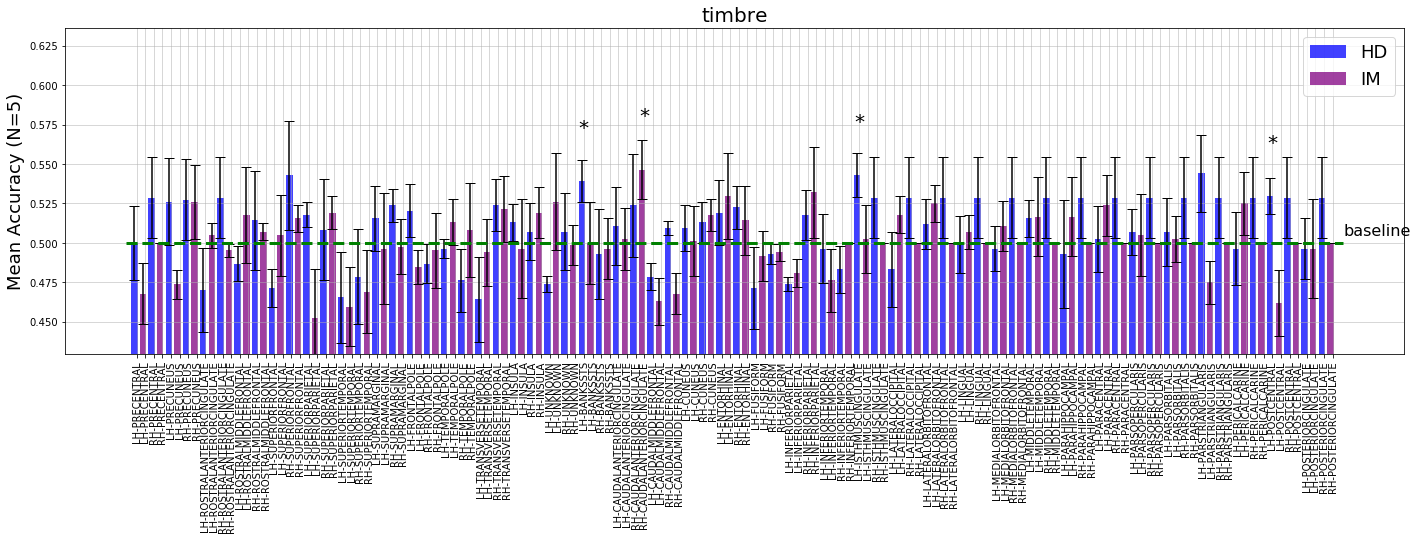

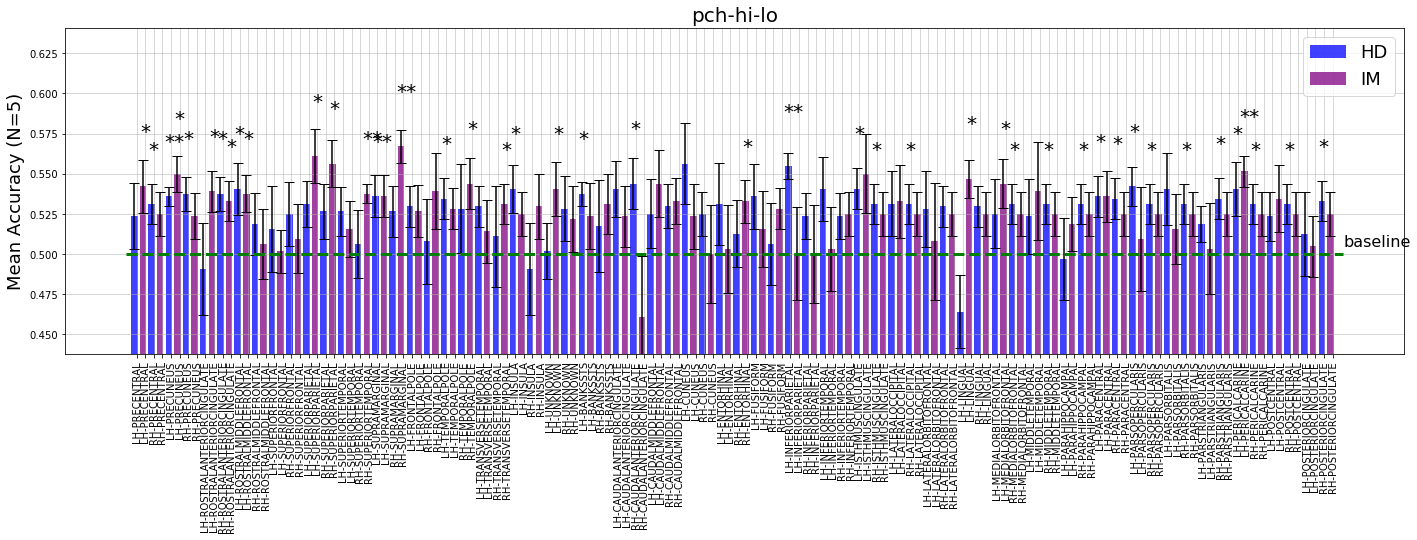

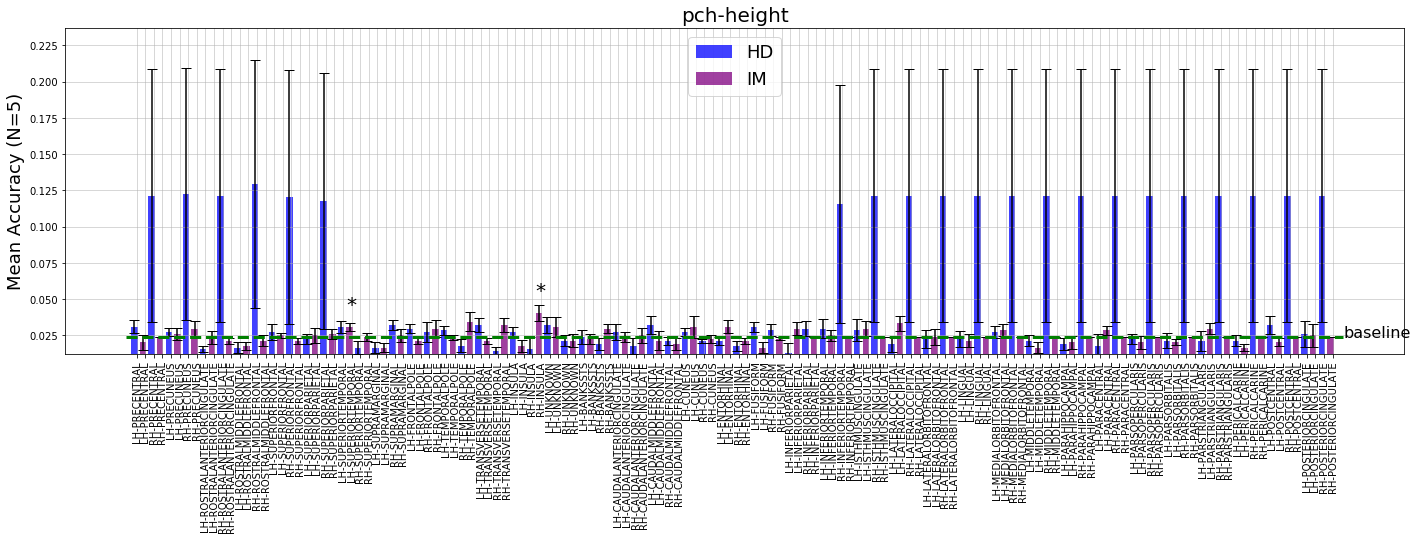

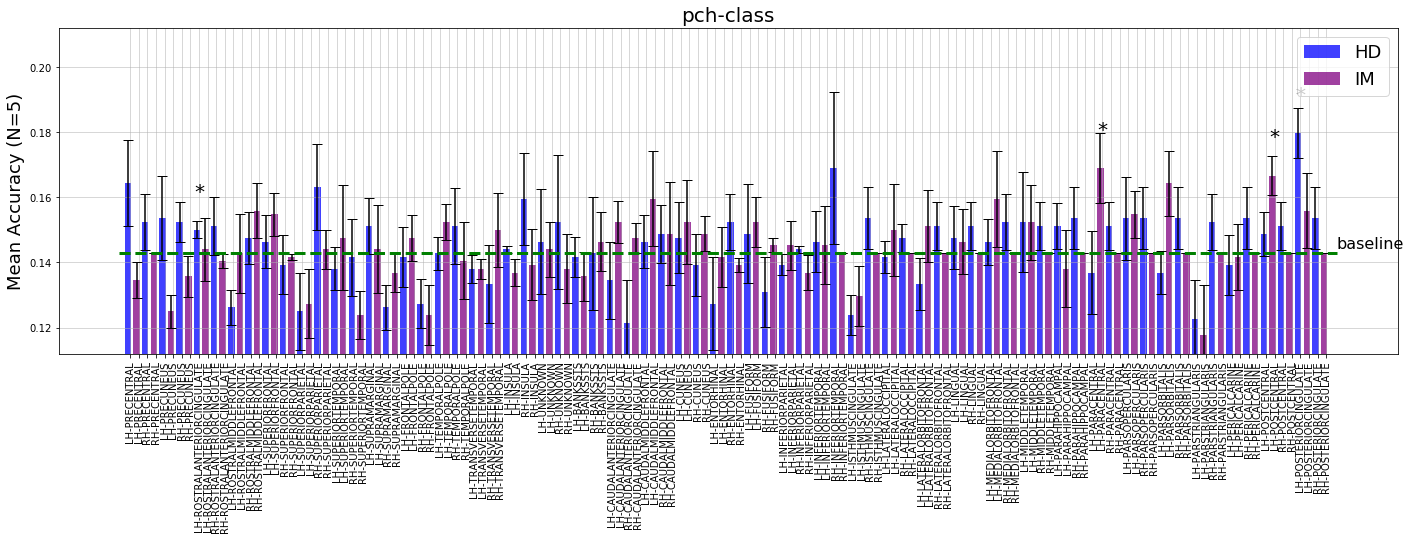

In [61]:
def get_stars(mn,bl,p):
    stars=''
    if mn>bl: # one-sided significance
        if p<0.05: stars='*'
        if p<0.005: stars='**'
        if p<0.0005: stars='***'
    return stars

def plot_group_results(show_null=False, w=1.5):
    global group_res # the keys determine the order of plots / elements
    dp = 3 if show_null else 2
    for task in group_res.keys():
        pl.figure(figsize=(24,6))
        pl.title(task,fontsize=20)
        xlabs = []
        pos=0
        mins=[]
        for roi in group_res[task].keys():
            for hemi in [0,1000]:
                hemiL = 'LH' if not hemi else 'RH'
                for cond in ['h','i']:
                    # Plot hist accuracy for conds x hemi with same bins
                    #task, roi_map[roi+hemi].replace('ctx-',''), cond.upper()
                    r=group_res[task][roi][hemiL][cond]
                    c=['blue','cyan'] if cond=='h' else ['purple','magenta']
                    pl.bar(pos, r['mn'], yerr=r['se'], color=c[0], width=w, align='center',alpha=0.75, ecolor='black', capsize=5)
                    mins.append(r['mn'])
                    if show_null:
                        pl.bar(pos+1, r['mn0'], yerr=r['se0'], color=c[1], width=w,align='center',alpha=0.75, ecolor='black', capsize=5)
                        mins.append(r['mn0'])
                    xlabs.append(roi_map[roi+hemi].replace('ctx-','').upper())
                    pos+=dp
        ax=pl.gca()
        mx=ax.get_ylim()[1]
        ax.set_ylim(array(mins).min()*0.95,mx*1.05)
        bl = 1.0 / len(r['ut'])
        pl.xticks(np.arange(len(xlabs))*dp+0.5,xlabs, rotation=90, fontsize=10)
        pl.ylabel('Mean Accuracy (N=5)', fontsize=18)
        pos=0
        leg = ['HD','HD0','IM','IM0'] if show_null else ['HD','IM']
        pl.legend(leg,fontsize=18)
        pl.plot([-dp,len(xlabs)*dp+1],[bl,bl],'g--',linewidth=3)
        pl.text(len(xlabs)*dp+1.,bl*1.01,'baseline',fontsize=16)
        pl.grid(linewidth=0.5)
        for roi in group_res[task].keys():
            for hemi in [0,1000]:
                hemiL = 'LH' if not hemi else 'RH'
                for cond in ['h','i']:
                    r=group_res[task][roi][hemiL][cond]
                    if r['tt'][0]>0:
                        p = r['tt'][1] # ttest 1samp
                        stars = get_stars(r['mn'],bl, p)
                        pl.text(pos-0.3-0.4*len(stars), r['mn']+mx*0.05, stars, color='k', fontsize=20)
                    if r['wx'][0]>0:
                        p = r['wx'][1] #  wilcoxon 1samp
                        stars = get_stars(r['mn'],bl, p)
                        pl.text(pos-0.3-0.4*len(stars), r['mn']+mx*0.75, stars, color='r', fontsize=20)
                    pos+=dp

# Plot group results
plot_group_results()

In [48]:
if 0:
    with open("group_res.pickle","wb") as f:
        pickle.dump(group_res, f)